Epoch 0,        Loss: 1.376e+00,        Physics Loss: 1.614e-01,        Data Loss: 1.807e-01,        IC Loss: 1.215e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 8.549e-01,        Physics Loss: 1.640e-01,        Data Loss: 1.232e-01,        IC Loss: 6.172e-01,        Loss Std: 1.058e-01
Epoch 200,        Loss: 7.281e-01,        Physics Loss: 3.747e-01,        Data Loss: 1.414e-01,        IC Loss: 4.095e-01,        Loss Std: 6.758e-02
Epoch 300,        Loss: 6.755e-01,        Physics Loss: 1.205e-01,        Data Loss: 1.103e-01,        IC Loss: 4.927e-01,        Loss Std: 7.193e-02
Epoch 400,        Loss: 6.551e-01,        Physics Loss: 1.551e-01,        Data Loss: 9.410e-02,        IC Loss: 4.271e-01,        Loss Std: 7.107e-02
Epoch 500,        Loss: 4.739e-01,        Physics Loss: 2.689e-02,        Data Loss: 5.487e-02,        IC Loss: 1.082e-02,        Loss Std: 1.673e-01
Epoch 600,        Loss: 6.837e-02,        Physics Loss: 2.979e-02,        Data Loss: 3.178e-02,       

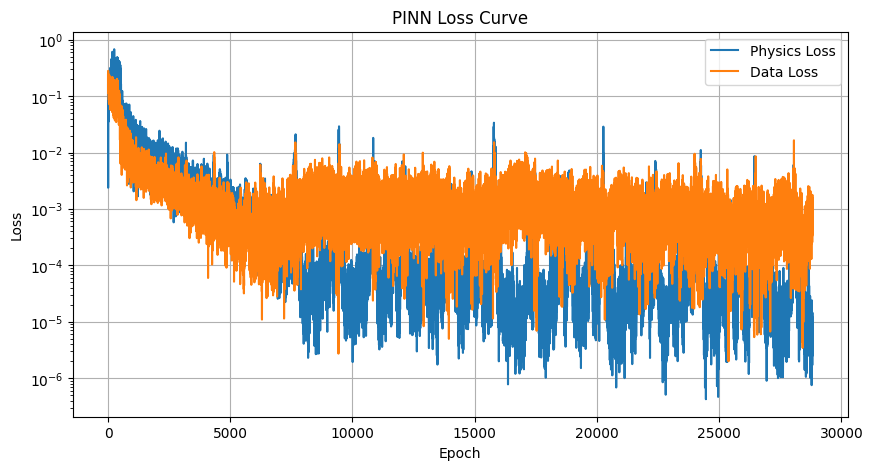

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

signorm = torch.nn.functional.sigmoid

# sine activeation function class
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, x):
        return torch.sin(x)


# cosine activeation function class
class Cosine(nn.Module):
    def __init__(self):
        super(Cosine, self).__init__()

    def forward(self, x):
        return torch.cos(x)


# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  # Input layer (time t)
            nn.GELU(),         # Activation function
            nn.Linear(50, 50), # Hidden layer
            nn.GELU(),         # Activation function
            nn.Linear(50, 50), # Hidden layer
            nn.GELU(),         # Activation functionv
            nn.Linear(50, 50), # Hidden layer
            nn.GELU(),         # Activation function
            nn.Linear(50, 1)   # Output layer (displacement x)
        )

    def forward(self, t):
        return self.net(t)

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0

    w = (w0**2-d**2)**.5
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*t)
    # sin = torch.sin(phi+w*t)
    exp = torch.exp(-d*t)
    x  = exp*2*A*cos
    return x


# Define the physics-informed loss
def physics_loss(model, mu, k):
    t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1).requires_grad_(True)
    tn = torch.FloatTensor(10, 1).uniform_(0, 1).requires_grad_(True)
    tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1).requires_grad_(True)
    t = torch.concat([
        t0, 
        tn, 
        tL
        ])
    
    # True displacement
    x_true = oscillator(d, w0, t).reshape(-1, 1)
    
    # Predict displacement
    x = model(t)
    
    # Automatically compute derivatives
    x_t = torch.autograd.grad(x,t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
    x_tt = torch.autograd.grad(x_t,t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
    
    # Compute the residual of the differential equation
    f = x_tt + mu*x_t + k*x

    # Initial condition losses
    dl = x-x_true

    # Return the mean squared error against the expected zero
    return (1e-4*torch.mean(f**2), torch.mean(dl**2), torch.mean(dl[0]**2))


# Initialize model, optimizer, and training parameters
model = PINN()
# model = SimpleTransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 3, 20
mu, k = 2*d, w0**2

d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])



plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(1000000):
    optimizer.zero_grad()

    ploss, dloss, icloss = physics_loss(model, mu, k)
    
    loss = ploss + icloss
    # loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())
    

# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PINN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()






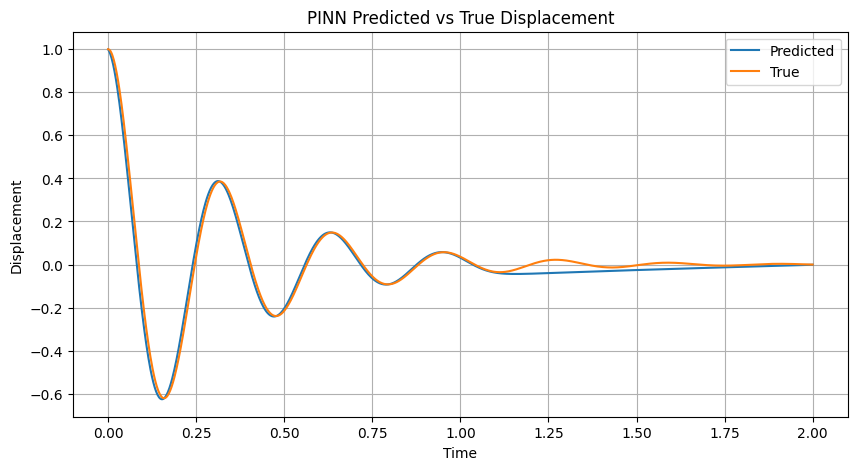

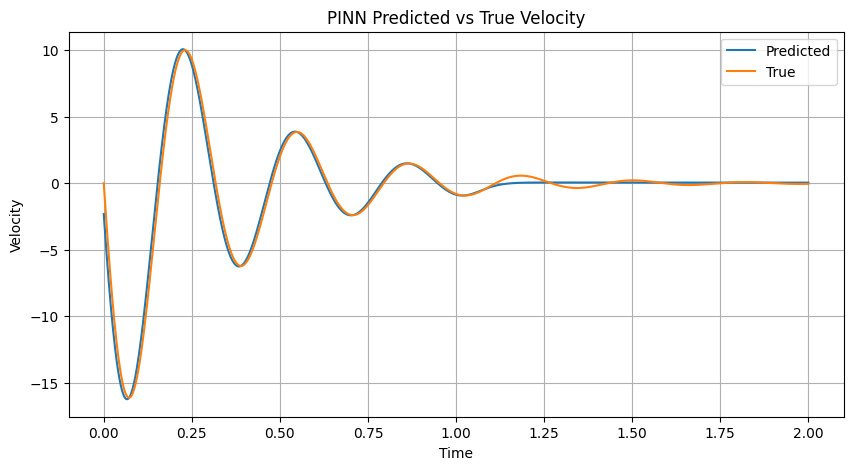

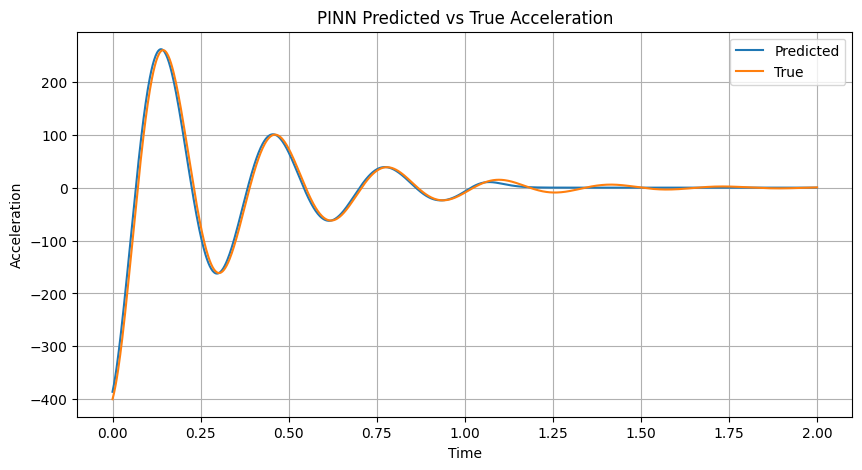

In [ ]:
#plot predicted vs true displacement
model.eval()
t = torch.linspace(0, 2, 1000).reshape(-1, 1).requires_grad_(True)
x = model(t)
x_true = oscillator(d, w0, t)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('PINN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()

#plot predicted vs true velocity
x_t = torch.autograd.grad(x,t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
x_t_true = torch.autograd.grad(x_true,t, torch.ones_like(x_true), create_graph=True)[0]  # dx/dt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_t.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_t_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('PINN Predicted vs True Velocity')
plt.legend()
plt.grid(True)

plt.show()

#plot predicted vs true acceleration
x_tt = torch.autograd.grad(x_t,t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
x_tt_true = torch.autograd.grad(x_t_true,t, torch.ones_like(x_t_true), create_graph=True)[0]  # d^2x/dt^2

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_tt.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_tt_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('PINN Predicted vs True Acceleration')
plt.legend()
plt.grid(True)

plt.show()

